In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns


In [2]:
# Configuração de imagem e dataset
image_size = 100
bs = 32  # Tamanho do batch

In [3]:
class Trainer:
    def __init__(self, model, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience=5, nameModel='model.pt'):
        self.model = model
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.funcao_erro = nn.CrossEntropyLoss()
        self.otimizador = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.otimizador, mode='min', factor=0.1, patience=3, verbose=True)
        self.patience = patience
        self.nameModel = nameModel

    def treinar_e_validar(self, epocas):
        historico = []
        melhor_acuracia = 0.0
        early_stop_counter = 0

        for epoca in range(epocas):
            inicio_epoca = time.time()
            print(f"\n\nÉpoca: {epoca + 1}/{epocas}")
            erro_treino, acuracia_treino = self.executar_fase('treino')
            erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

            fim_epoca = time.time()
            print(f"Época {epoca + 1}/{epocas}, Treino: Erro: {erro_treino:.4f}, Acurácia: {acuracia_treino * 100:.2f}%, "
                  f"Validação: Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%, Tempo: {fim_epoca - inicio_epoca:.2f}s")

            historico.append([erro_treino, erro_validacao, acuracia_treino, acuracia_validacao])
            self.scheduler.step(erro_validacao)

            # Early stopping
            if acuracia_validacao > melhor_acuracia:
                melhor_acuracia = acuracia_validacao
                torch.save(self.model.state_dict(), self.nameModel)
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= self.patience:
                print("Parando o treinamento devido ao early stopping.")
                break

        # Calcular métricas finais
        self.calcular_metricas(predicoes_validacao, labels_validacao)
        return historico

    def executar_fase(self, fase, return_predictions=False):
        if fase == 'treino':
            self.model.train()
            data_loader = self.data_loader_treino
            num_imagens = self.num_imagens_treino
        else:
            self.model.eval()
            data_loader = self.data_loader_validacao
            num_imagens = self.num_imagens_validacao

        erro_total = 0.0
        acuracia_total = 0.0
        todas_predicoes = []
        todas_labels = []

        with torch.set_grad_enabled(fase == 'treino'):
            for entradas, labels in data_loader:
                entradas, labels = entradas.to(self.device), labels.to(self.device)

                if fase == 'treino':
                    self.otimizador.zero_grad()

                saidas = self.model(entradas)
                erro = self.funcao_erro(saidas, labels)

                if fase == 'treino':
                    erro.backward()
                    self.otimizador.step()

                erro_total += erro.item() * entradas.size(0)
                _, predicoes = torch.max(saidas, 1)
                acuracia_total += (predicoes == labels).sum().item()

                if return_predictions:
                    todas_predicoes.extend(predicoes.cpu().numpy())
                    todas_labels.extend(labels.cpu().numpy())

        erro_medio = erro_total / num_imagens
        acuracia_media = acuracia_total / num_imagens

        if return_predictions:
            return erro_medio, acuracia_media, todas_predicoes, todas_labels
        else:
            return erro_medio, acuracia_media

    def calcular_metricas(self, predicoes, labels):
        acuracia = accuracy_score(labels, predicoes)
        precisao = precision_score(labels, predicoes, average='weighted')
        recall = recall_score(labels, predicoes, average='weighted')
        f1 = f1_score(labels, predicoes, average='weighted')

        print("\nMétricas de Validação:")
        print(f"Acurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        print("\nRelatório de Classificação:")
        print(classification_report(labels, predicoes))

        self.plotar_matriz_confusao(labels, predicoes)

    def plotar_matriz_confusao(self, labels, predicoes):
        matriz_confusao = confusion_matrix(labels, predicoes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=self.data_loader_treino.dataset.classes, yticklabels=self.data_loader_treino.dataset.classes)
        plt.ylabel('Classe Verdadeira')
        plt.xlabel('Classe Prevista')
        plt.title('Matriz de Confusão')
        plt.show()


In [4]:
class DataLoaderSetup:
    def __init__(self, dataset_path, image_size=224, batch_size=32):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.batch_size = batch_size

    def get_transforms(self):
        transformacoes_de_imagens = {
            'treino': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'validacao': transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.CenterCrop(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return transformacoes_de_imagens

    def load_data(self):
        transformacoes = self.get_transforms()
        pasta_treino = os.path.join(self.dataset_path, 'treino')
        pasta_validacao = os.path.join(self.dataset_path, 'validacao')

        data = {
            'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes['treino']),
            'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes['validacao'])
        }
        return data

    def get_data_loaders(self):
        data = self.load_data()
        data_loader_treino = DataLoader(data['treino'], batch_size=self.batch_size, shuffle=True)
        data_loader_validacao = DataLoader(data['validacao'], batch_size=self.batch_size, shuffle=True)
        return data_loader_treino, data_loader_validacao, len(data['treino']), len(data['validacao']), len(data['treino'].classes)


In [5]:
# Definição da classe do modelo Custom ResNet50
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=None):
        super(CustomResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        for param in list(self.resnet50.parameters())[-4:]:
            param.requires_grad = True
        self.num_features = self.resnet50.fc.in_features
        
        self.num_classes = num_classes
        if num_classes is not None:
            self.set_num_classes(num_classes)
    
    def set_num_classes(self, num_classes):
        """Define o número de classes dinamicamente e substitui a camada fc"""
        self.num_classes = num_classes
        self.resnet50.fc = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.resnet50(x)

In [6]:
# Função para avaliar o modelo
def avaliar_modelo(modelo, data_loader, device):
    modelo.to(device)
    modelo.eval()  # Colocar o modelo em modo de avaliação
    todas_predicoes = []
    todas_labels = []

    with torch.no_grad():
        for entradas, labels in data_loader:
            entradas, labels = entradas.to(device), labels.to(device)
            saidas = modelo(entradas)
            _, predicoes = torch.max(saidas, 1)

            todas_predicoes.extend(predicoes.cpu().numpy())
            todas_labels.extend(labels.cpu().numpy())

    # Converter listas para arrays numpy
    todas_predicoes = np.array(todas_predicoes)
    todas_labels = np.array(todas_labels)

    # Calcular acurácia
    acuracia = accuracy_score(todas_labels, todas_predicoes)

    # Calcular F1-score (média macro para considerar cada classe igualmente)
    f1 = f1_score(todas_labels, todas_predicoes, average='macro')

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(todas_labels, todas_predicoes)

    return acuracia, f1, matriz_confusao

In [7]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(matriz_confusao, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3712, Acurácia: 48.35%, Validação: Erro: 1.7365, Acurácia: 35.03%, Tempo: 796.60s


Época: 2/30
Época 2/30, Treino: Erro: 1.1982, Acurácia: 54.60%, Validação: Erro: 2.3860, Acurácia: 26.00%, Tempo: 514.36s


Época: 3/30
Época 3/30, Treino: Erro: 1.1507, Acurácia: 56.25%, Validação: Erro: 2.0961, Acurácia: 28.27%, Tempo: 411.25s


Época: 4/30
Época 4/30, Treino: Erro: 1.1290, Acurácia: 56.97%, Validação: Erro: 1.8638, Acurácia: 43.92%, Tempo: 411.32s


Época: 5/30
Época 5/30, Treino: Erro: 1.1010, Acurácia: 57.78%, Validação: Erro: 21.0648, Acurácia: 27.13%, Tempo: 413.15s


Época: 6/30
Época 6/30, Treino: Erro: 1.0453, Acurácia: 59.64%, Validação: Erro: 1.7197, Acurácia: 38.09%, Tempo: 412.62s


Época: 7/30
Época 7/30, Treino: Erro: 1.0259, Acurácia: 60.55%, Validação: Erro: 1.6031, Acurácia: 41.11%, Tempo: 411.97s


Época: 8/30
Época 8/30, Treino: Erro: 1.0095, Acurácia: 61.24%, Validação: Erro: 13.1934, Acurácia: 21.37%, Tempo: 412.54s


Époc

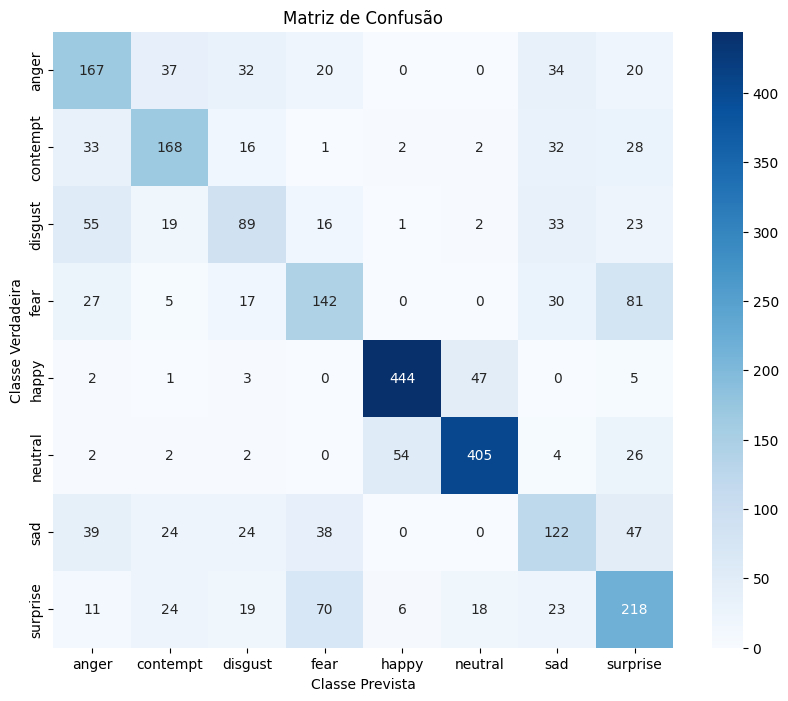

Acurácia: 0.6241109530583214
F1-score: 0.5831356615433227
Matriz de Confusão:
[[167  37  32  20   0   0  34  20]
 [ 33 168  16   1   2   2  32  28]
 [ 55  19  89  16   1   2  33  23]
 [ 27   5  17 142   0   0  30  81]
 [  2   1   3   0 444  47   0   5]
 [  2   2   2   0  54 405   4  26]
 [ 39  24  24  38   0   0 122  47]
 [ 11  24  19  70   6  18  23 218]]


In [8]:
# Configurações
dataset_path = '../dlib/dados/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'dlib.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")